<a href="https://colab.research.google.com/github/haritraman/Speech-Emotion-Recognition-SER-/blob/main/Copy_of_original_Emo_db.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- Run this cell only ONCE per session ---

# 1. Install Dependencies
print("Installing required libraries...")
!pip install -q resampy audiomentations
print("✅ Installation complete.")

# 2. Import Libraries
import os
import zipfile
import librosa
import numpy as np
import time
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# 3. Mount Google Drive
print("\nMounting Google Drive...")
try:
    drive.mount('/content/drive', force_remount=True)
    print("✅ Drive mounted successfully.")
except Exception as e:
    print(f"🚨 Error mounting drive: {e}")
    raise


Installing required libraries...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.4/109.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 14.0 MB/s eta 0:00:00
✅ Installation complete.

Mounting Google Drive...
Mounted at /content/drive
✅ Drive mounted successfully.


In [ ]:
# 4. Unzip the Dataset
zip_file_path = '/content/drive/MyDrive/archive.zip'
extract_dir = '/content/drive/MyDrive/EMO-DB/wav/'

print(f"\nUnzipping '{zip_file_path}'...")
if not os.path.exists(extract_dir):
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall('/content/drive/MyDrive/EMO-DB/')
        print("✅ Unzipping complete.")
    except FileNotFoundError:
        print(f"🚨 ERROR: The file '{zip_file_path}' was not found.")
        raise
else:
    print("✅ Dataset already unzipped.")

# 5. Confirm Dataset Path
def find_dataset_folder(base_path):
    for dirpath, dirnames, filenames in os.walk(base_path):
        if any(f.endswith('.wav') for f in filenames):
            print(f"✅ Found audio files in: {dirpath}")
            return dirpath
    return None

DATA_PATH = find_dataset_folder(extract_dir)
if DATA_PATH is None:
    print("🚨 ERROR: Could not locate the EMO-DB dataset folder.")
    raise FileNotFoundError("Dataset folder not found.")



Unzipping '/content/drive/MyDrive/archive.zip'...
✅ Dataset already unzipped.
✅ Found audio files in: /content/drive/MyDrive/EMO-DB/wav/


In [ ]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import tqdm

# Define augmentation pipeline
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_shift=-0.5, max_shift=0.5, p=0.5),
])

# Load raw data
def load_raw_data(data_path):
    raw_data = []
    labels = []
    # EMO-DB emotion map
    emotion_map = {
        'W': 'angry',
        'L': 'boredom',
        'E': 'disgust',
        'A': 'fearful',
        'F': 'happy',
        'T': 'sad',
        'N': 'neutral'
    }

    print("\nLoading raw audio files from EMO-DB...")
    global initial_sample_rate
    initial_sample_rate = None

    all_files = []
    for root, _, files in os.walk(data_path):
        for file_name in files:
            if file_name.endswith('.wav'):
                all_files.append(os.path.join(root, file_name))

    if not all_files:
        print(f"🚨 ERROR: No .wav files found in {data_path}.")
        return [], []

    print(f"Found {len(all_files)} .wav files. Processing...")

    for file_path in tqdm.tqdm(all_files, desc="Processing audio files"):
        try:
            file_name = os.path.basename(file_path)
            if len(file_name) < 6:
                continue
            emotion_code = file_name[5]  # e.g., '03a01Wa.wav' -> 'W'
            if emotion_code not in emotion_map:
                continue

            emotion = emotion_map[emotion_code]
            audio_data, sample_rate = librosa.load(file_path, sr=None)
            if initial_sample_rate is None:
                initial_sample_rate = sample_rate

            raw_data.append(audio_data)
            labels.append(emotion)
        except Exception as e:
            print(f"\nWarning: Skipping {file_name} due to error: {e}")
            continue

    print(f"\n✅ Loaded {len(raw_data)} valid audio files.")
    return raw_data, np.array(labels)

# Load dataset
X_raw, y_raw = load_raw_data(DATA_PATH)
if len(X_raw) == 0:
    raise ValueError("No audio data was loaded. Please check your dataset path.")



Loading raw audio files from EMO-DB...
Found 535 .wav files. Processing...


Processing audio files: 100%|██████████| 535/535 [00:26<00:00, 20.41it/s] 


✅ Loaded 535 valid audio files.


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Label encode
le = LabelEncoder()
y_encoded = le.fit_transform(y_raw)
y_categorical = to_categorical(y_encoded)

# Split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)

# Apply augmentation
print("\nAugmenting training data...")
X_train_augmented_audio = []
y_train_augmented = []
for i, audio in tqdm.tqdm(enumerate(X_train_raw), total=len(X_train_raw), desc="Augmenting training data"):
    X_train_augmented_audio.append(audio)
    y_train_augmented.append(y_train[i])
    augmented_audio = augment(samples=audio, sample_rate=initial_sample_rate)
    X_train_augmented_audio.append(augmented_audio)
    y_train_augmented.append(y_train[i])
print(f"✅ Augmentation complete. Training set size: {len(X_train_augmented_audio)} samples.")

# Extract MFCC features
def extract_features(audio_list):
    feature_list = []
    for audio in tqdm.tqdm(audio_list, desc="Extracting features"):
        mfccs = librosa.feature.mfcc(y=audio, sr=initial_sample_rate, n_mfcc=40)
        feature_list.append(mfccs)
    return feature_list

print("\nExtracting MFCC features...")
X_train_features = extract_features(X_train_augmented_audio)
X_test_features = extract_features(X_test_raw)

# Pad sequences
max_pad_len = max(x.shape[1] for x in X_train_features + X_test_features)

def pad_features(features, max_len):
    return np.array([np.pad(feat, ((0, 0), (0, max_len - feat.shape[1])), mode='constant') for feat in features])

print("Padding features...")
X_train_padded = pad_features(X_train_features, max_pad_len).transpose((0, 2, 1))
X_test_padded = pad_features(X_test_features, max_pad_len).transpose((0, 2, 1))
y_train_augmented = np.array(y_train_augmented)

print("✅ Data ready for model training.")
print(f"Train shape: {X_train_padded.shape}, Test shape: {X_test_padded.shape}")



Augmenting training data...


Augmenting training data: 100%|██████████| 428/428 [00:08<00:00, 51.01it/s]


✅ Augmentation complete. Training set size: 856 samples.

Extracting MFCC features...


Extracting features: 100%|██████████| 107/107 [00:00<00:00, 167.97it/s]


Padding features...
✅ Data ready for model training.
Train shape: (856, 281, 40), Test shape: (107, 281, 40)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization

# Model architecture
model = Sequential([
    Conv1D(1024, 5, padding='same', input_shape=(X_train_padded.shape[1], X_train_padded.shape[2])),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=4),
    Dropout(0.3), # Increased dropout

    Conv1D(1024, 5, padding='same'),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=4),
    Dropout(0.3), # Increased dropout

    Conv1D(512, 5, padding='same'),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=4),
    Dropout(0.3), # Increased dropout

    LSTM(128),
    Dropout(0.4), # Increased dropout

    Dense(y_categorical.shape[1], activation='softmax')
])
model.summary()

# Compile
opt = Adam(learning_rate=0.00005) # Reduced learning rate
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('best_model_emodb.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=False, verbose=1) # Increased patience, changed restore_best_weights to False
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.000001, verbose=1) # Added ReduceLROnPlateau

# Train
print("\n--- Training on EMO-DB dataset ---")
history = model.fit(
    X_train_padded, y_train_augmented,
    batch_size=32,
    epochs=200, # Increased epochs
    validation_data=(X_test_padded, y_test),
    callbacks=[checkpoint, early_stop, reduce_lr], # Added ReduceLROnPlateau to callbacks
    verbose=2
)
print("--- Training finished ---")

# Evaluate
score = model.evaluate(X_test_padded, y_test, verbose=0)
print(f"✅ Final Test Accuracy: {score[1]*100:.2f}%")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 281, 1024)      │       205,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 281, 1024)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 281, 1024)      │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 70, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 70, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 70, 1024)       │     5,243,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 70, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 70, 1024)       │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 17, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 17, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 17, 512)        │     2,621,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 17, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 17, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 4, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 4, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 128)            │       328,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,411,015 (32.09 MB)

 Trainable params: 8,405,895 (32.07 MB)

 Non-trainable params: 5,120 (20.00 KB)


--- Training on EMO-DB dataset ---
Epoch 1/200

Epoch 1: val_accuracy improved from -inf to 0.28972, saving model to best_model_emodb.keras
27/27 - 5s - 190ms/step - accuracy: 0.2629 - loss: 1.8408 - val_accuracy: 0.2897 - val_loss: 1.8571 - learning_rate: 5.0000e-05
Epoch 2/200

Epoch 2: val_accuracy improved from 0.28972 to 0.34579, saving model to best_model_emodb.keras
27/27 - 2s - 63ms/step - accuracy: 0.3586 - loss: 1.6964 - val_accuracy: 0.3458 - val_loss: 1.7057 - learning_rate: 5.0000e-05
Epoch 3/200

Epoch 3: val_accuracy improved from 0.34579 to 0.41121, saving model to best_model_emodb.keras
27/27 - 3s - 119ms/step - accuracy: 0.4276 - loss: 1.5480 - val_accuracy: 0.4112 - val_loss: 1.5217 - learning_rate: 5.0000e-05
Epoch 4/200

Epoch 4: val_accuracy improved from 0.41121 to 0.46729, saving model to best_model_emodb.keras
27/27 - 2s - 76ms/step - accuracy: 0.4498 - loss: 1.4351 - val_accuracy: 0.4673 - val_loss: 1.3697 - learning_rate: 5.0000e-05
Epoch 5/200

Epoch 5: val

## Enhance data augmentation

### Subtask:
Implement additional audio augmentation techniques to increase the diversity and size of the training dataset. This could include techniques like adding background noise, changing speed, or applying spectral augmentations.

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step


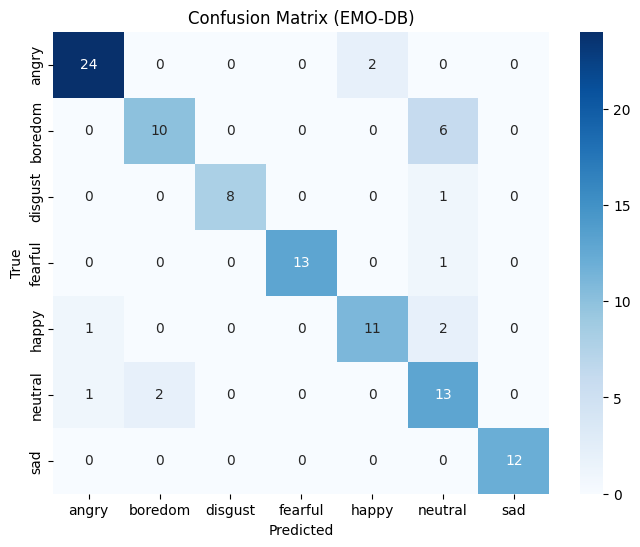

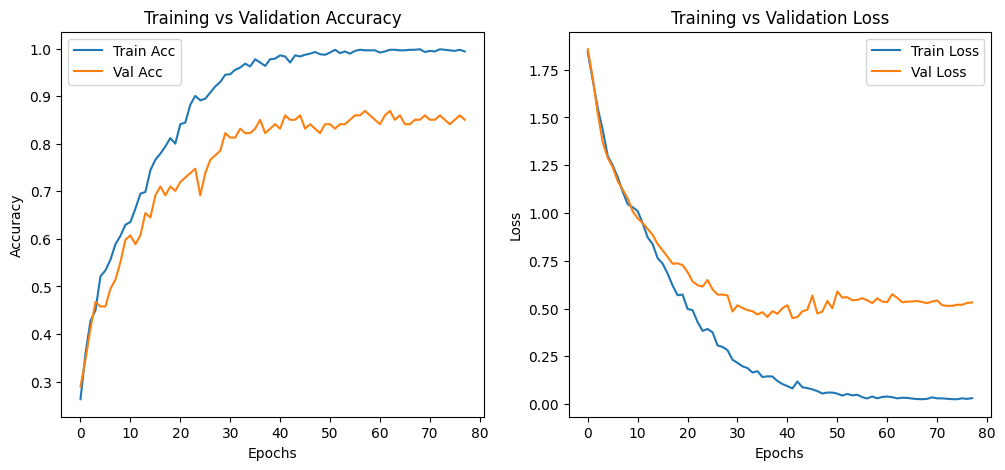

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Predictions
y_pred = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (EMO-DB)")
plt.show()

# Training vs Validation Accuracy/Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


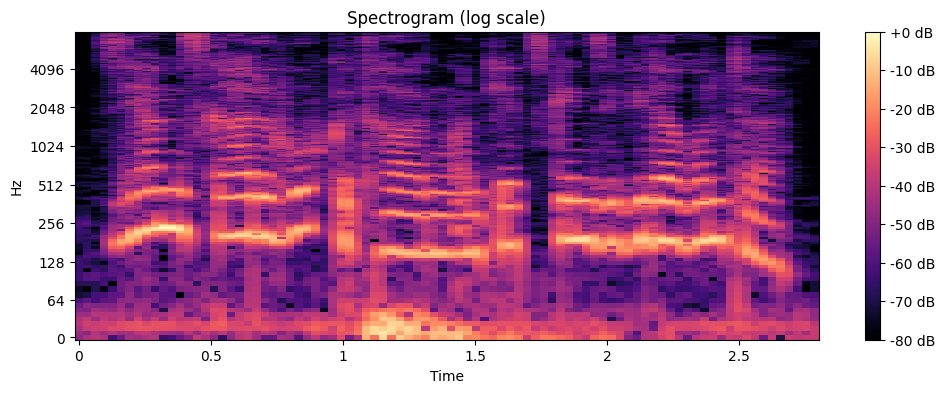

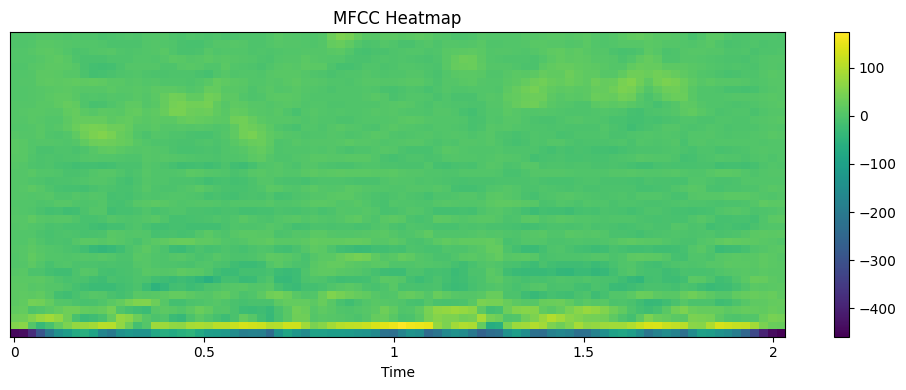

In [ ]:
import librosa.display

# Pick a random sample
sample_audio = X_train_raw[0]
plt.figure(figsize=(12, 4))
D = librosa.amplitude_to_db(np.abs(librosa.stft(sample_audio)), ref=np.max)
librosa.display.specshow(D, sr=initial_sample_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (log scale)")
plt.show()

# MFCC Heatmap
mfcc = librosa.feature.mfcc(y=sample_audio, sr=initial_sample_rate, n_mfcc=40)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time', cmap='viridis')
plt.colorbar()
plt.title("MFCC Heatmap")
plt.tight_layout()
plt.show()


# Task
Improve the accuracy of the model to 94% by adjusting hyperparameters and enhancing data augmentation.

## Adjust hyperparameters

### Subtask:
Modify learning rate, dropout, and potentially add more epochs or adjust learning rate reduction parameters.


**Reasoning**:
Reviewing the current hyperparameters and model definition to identify areas for adjustment based on the instructions. I will focus on modifying the learning rate, dropout, and potentially increasing epochs or adjusting learning rate reduction parameters. I will start by slightly increasing the epochs, reducing the initial learning rate, and adjusting the Rlrp callback. I will then adjust dropout rates in the model definition.

